In [1]:
#reload modules
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [2]:
#read in the two files
model = 'h100_llama3.3_demo'
inference_load = pd.read_csv(f"inference_load.freq_{model}.csv", parse_dates=['StartTime', 'EndTime'])
nvidia_log = pd.read_csv(f"nvidia_smi_log.freq_{model}.csv", parse_dates=['timestamp'])
default_inference_load = pd.read_csv(f"inference_load.default_{model}.csv", parse_dates=['StartTime', 'EndTime'])
default_nvidia_log = pd.read_csv(f"nvidia_smi_log.default_{model}.csv", parse_dates=['timestamp'])

In [3]:
inference_load.dtypes

StartTime                 datetime64[ns]
EndTime                   datetime64[ns]
TotalTokens                        int64
TotalDuration(seconds)           float64
TokensPerSecond                  float64
LongOrShortPrompt                 object
Model                             object
dtype: object

In [4]:
inference_load.head()

,StartTime,EndTime,TotalTokens,TotalDuration(seconds),TokensPerSecond,LongOrShortPrompt,Model
0,2025-01-25 17:39:20.416,2025-01-25 17:41:58.370,1272,157.366360,8.083049,Long,llama3.3
1,2025-01-25 17:41:58.504,2025-01-25 17:42:00.019,29,1.512504,19.173496,Short,llama3.3
2,2025-01-25 17:42:00.022,2025-01-25 17:44:49.006,1756,168.978590,10.391849,Long,llama3.3
3,2025-01-25 17:44:50.128,2025-01-25 17:46:43.340,1354,113.206440,11.960450,Long,llama3.3
4,2025-01-25 17:46:43.380,2025-01-25 17:46:44.458,29,1.075647,26.960527,Short,llama3.3


In [5]:
nvidia_log.dtypes

timestamp                datetime64[ns]
index                             int64
name                             object
utilization.gpu(%)                int64
utilization.memory(%)             int64
memory.total(MiB)                 int64
memory.free(MiB)                  int64
memory.used(MiB)                  int64
temperature.gpu(C)                int64
gpu.frequency(Ghz)                int64
vram.frequency(Ghz)               int64
power.limit(W)                  float64
power.draw(W)                   float64
dtype: object

In [6]:
nvidia_log.head()

,timestamp,index,name,utilization.gpu(%),utilization.memory(%),memory.total(MiB),memory.free(MiB),memory.used(MiB),temperature.gpu(C),gpu.frequency(Ghz),vram.frequency(Ghz),power.limit(W),power.draw(W)
0,2025-01-25 17:39:19.616,0,NVIDIA H100 80GB HBM3,0,0,81559,80992,4,44,345,2619,700.0,73.11
1,2025-01-25 17:39:19.735,0,NVIDIA H100 80GB HBM3,0,0,81559,80992,4,44,345,2619,700.0,73.03
2,2025-01-25 17:39:19.853,0,NVIDIA H100 80GB HBM3,0,0,81559,80992,4,44,345,2619,700.0,73.07
3,2025-01-25 17:39:19.969,0,NVIDIA H100 80GB HBM3,0,0,81559,80992,4,44,345,2619,700.0,73.09
4,2025-01-25 17:39:20.086,0,NVIDIA H100 80GB HBM3,0,0,81559,80992,4,44,345,2619,700.0,73.08


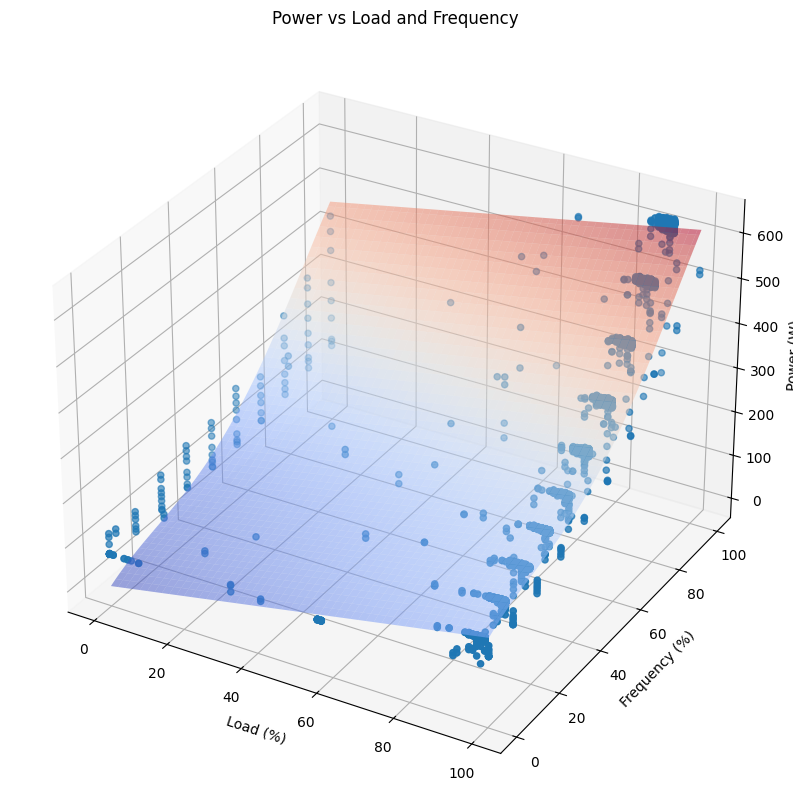

In [7]:
#we want two loadlines one for long and one for short prompt
#we will plot three vars, utilization.gpu(%), gpu.frequency(Ghz), power.draw(W)
#we will plot these three vars for both long and short prompt
vars = ["utilization.gpu(%)", "gpu.frequency(Ghz)", "power.draw(W)"]
#could eventually filter to just the timespans of the actual work but I don't think thats necessary for now
# for prompt in ["Long", "Short"]:
#     #filter the data
#     inference_load_filtered = inference_load[inference_load["LongOrShortPrompt"] == prompt]
#     #now get the data from nvidia between each start and end time
#     prompt_data = pd.DataFrame()
#     for index, row in inference_load_filtered.iterrows():
#         start_time = row["StartTime"]
#         end_time = row["EndTime"]
#         nvidia_log_filtered = nvidia_log[(nvidia_log["timestamp"] >= start_time) & (nvidia_log["timestamp"] <= end_time)]
#         prompt_data = pd.concat([prompt_data, nvidia_log_filtered]) 
#get the earliest start time and latest end time
earliest_start_time = inference_load["StartTime"].min()
latest_end_time = inference_load["EndTime"].max()
#filter the nvidia log to just this time
prompt_data = nvidia_log[(nvidia_log["timestamp"] >= earliest_start_time) & (nvidia_log["timestamp"] <= latest_end_time)]

#now group the data
grouped_data = prompt_data.groupby(vars)[vars].mean().reset_index(drop=True)
#find the min and max of each group
grouped_data["min_gpu.frequency(Ghz)"] = grouped_data['gpu.frequency(Ghz)'].min()
grouped_data["max_gpu.frequency(Ghz)"] = grouped_data['gpu.frequency(Ghz)'].max()
grouped_data['min_power.draw(W)'] = grouped_data['power.draw(W)'].min()
grouped_data['max_power.draw(W)'] = grouped_data['power.draw(W)'].max()
grouped_data['min_utilization.gpu(%)'] = grouped_data['utilization.gpu(%)'].min()
grouped_data['max_utilization.gpu(%)'] = grouped_data['utilization.gpu(%)'].max()

#add a col to show each as a percentage of the max
grouped_data["load%of max"] = (grouped_data["utilization.gpu(%)"] - grouped_data["min_utilization.gpu(%)"]) / (grouped_data["max_utilization.gpu(%)"] - grouped_data["min_utilization.gpu(%)"])
#grouped_data["power%of max"] = (grouped_data["power.draw(W)"] - grouped_data["min_power.draw(W)"]) / (grouped_data["max_power.draw(W)"] - grouped_data["min_power.draw(W)"])
grouped_data["frequency%of max"] = (grouped_data["gpu.frequency(Ghz)"] - grouped_data["min_gpu.frequency(Ghz)"]) / (grouped_data["max_gpu.frequency(Ghz)"] - grouped_data["min_gpu.frequency(Ghz)"])
#if frequency%of max is nan then that just meant the frequency didnt change to we can set it to 0
grouped_data["frequency%of max"] = grouped_data["frequency%of max"].fillna(0)

load_data = grouped_data[['load%of max', 'power.draw(W)', 'frequency%of max']] * 100
#plot the 3d data      
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(load_data['load%of max'], load_data['frequency%of max'], load_data['power.draw(W)']/100.0)
ax.set_xlabel('Load (%)')
ax.set_ylabel('Frequency (%)')
ax.set_zlabel('Power (W)')

#add a fit surface to the data
# def func(data, a, b, c):
#     x, y = data
#     return a * x + b * y + c
def func(data, a, b, c, d, e):
    load, freq = data
    return a * load + b * freq + (freq**2) * c +  (freq**3) * d + (freq**4) * e
# Fit the data to the model
data = (load_data['load%of max'], load_data['frequency%of max'])
popt, _ = curve_fit(func, data, load_data['power.draw(W)']/100.0, maxfev=50000)
# Create a grid of data
x = np.linspace(load_data['load%of max'].min(), load_data['load%of max'].max(), 100)
y = np.linspace(load_data['frequency%of max'].min(), load_data['frequency%of max'].max(), 100)
x, y = np.meshgrid(x, y)
z = func((x, y), *popt)
# Plot the surface
ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.5)
plt.title('Power vs Load and Frequency')
plt.show()


Model coefficients:
load: -439.04858415768035
freq: 109.10038503640695
load^2: 1091.8139567260887
load freq: 271.46571234463823
freq^2: -160.72331204210056
load^3: -589.6735202082286
load^2 freq: -239.66844910711538
load freq^2: 275.60223227977525
freq^3: 218.14233352144248
Intercept: 89.06546392485492
Model Performance:
R-squared: 0.9873
RMSE: 16.2261
MAE: 8.3190


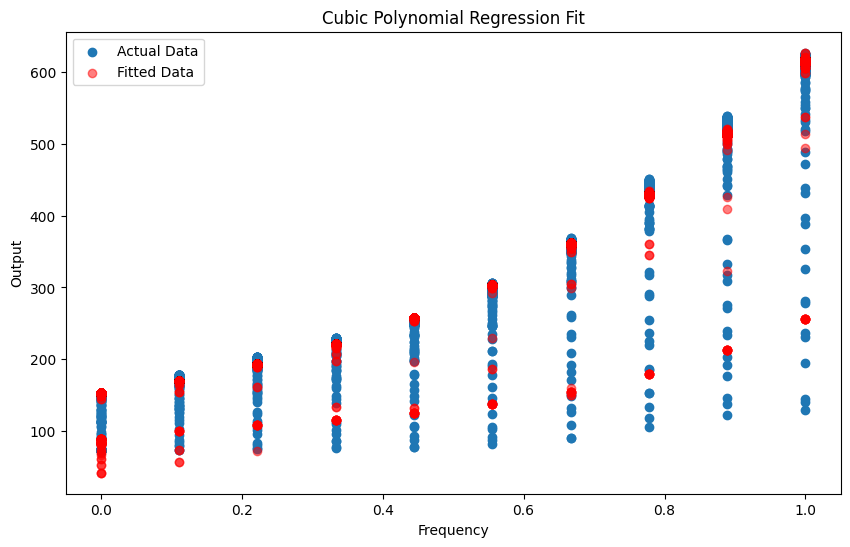

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
# Example column names (adjust if your column names are different)
# - For load: 'load_percentage'
# - For frequency: 'frequency_percentage'
# - For output: 'power_draw_W' or any other target metric

# Rename columns if necessary
grouped_data2 = grouped_data.rename(columns={
    'load%of max': 'load',          # Adjust according to your column names
    'frequency%of max': 'freq',
    'power.draw(W)': 'output'       # Replace 'output' with your target variable
}, inplace=False)

# Extract variables
load = grouped_data2['load'].values.reshape(-1, 1)
freq = grouped_data2['freq'].values.reshape(-1, 1)
X = np.hstack((load, freq))  # Combine load and freq into a single feature matrix
y = grouped_data2['output'].values  # Target variable

# Create polynomial features up to degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
# Fit the linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_poly, y)
# Get the model coefficients
coefficients = model.coef_
intercept = model.intercept_

# Display the coefficients with their corresponding feature names
print("Model coefficients:")
feature_names = poly.get_feature_names_out(['load', 'freq'])
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")
print(f"Intercept: {intercept}")
# Make predictions using the model
y_pred = model.predict(X_poly)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"Model Performance:")
print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(freq, y, label='Actual Data')
plt.scatter(freq, y_pred, label='Fitted Data', color='red', alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('Output')
plt.title('Cubic Polynomial Regression Fit')
plt.legend()
plt.show()

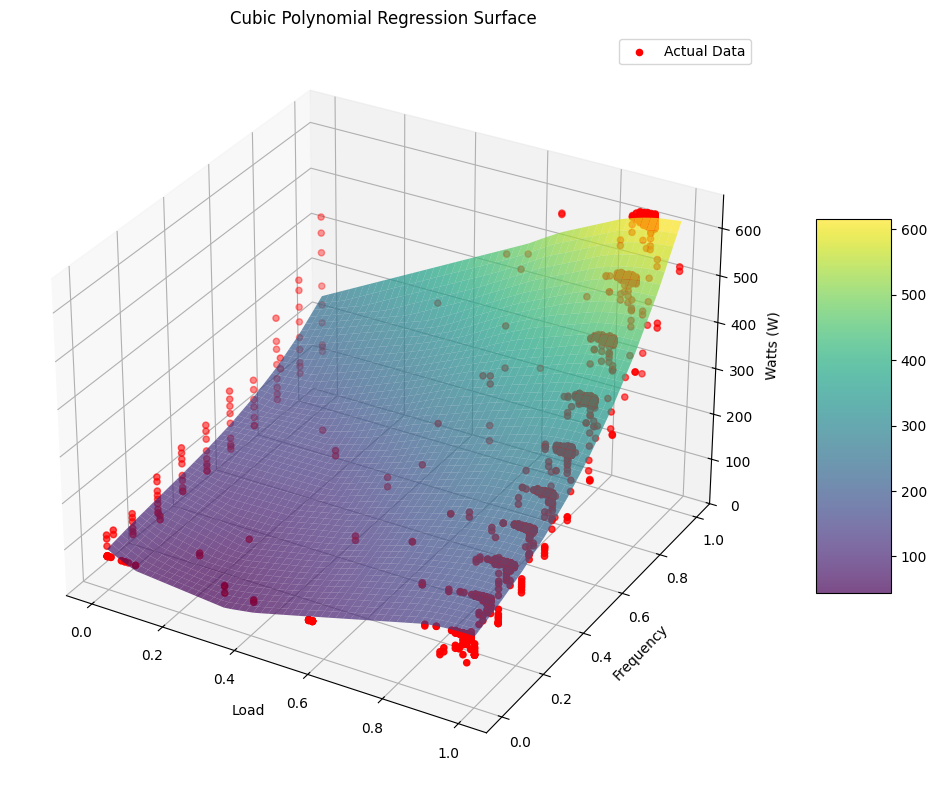

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Assuming you have the following variables:
# - load: array of load values
# - freq: array of frequency values
# - y: array of actual output values
# - y_pred: array of predicted output values from your model

# Ensure that load and freq are 1D arrays
load = load.flatten()
freq = freq.flatten()
y_pred = y_pred.flatten()

# Create a DataFrame with your data
data = pd.DataFrame({
    'load': load,
    'freq': freq,
    'predicted_output': y_pred
})

# Create a grid for load and frequency
load_unique = np.linspace(load.min(), load.max(), 50)
freq_unique = np.linspace(freq.min(), freq.max(), 50)
load_grid, freq_grid = np.meshgrid(load_unique, freq_unique)

# Interpolate the predicted output onto the grid
from scipy.interpolate import griddata

# Points where you have data
points = np.column_stack((data['load'], data['freq']))
values = data['predicted_output']

# Grid the data
output_grid = griddata(points, values, (load_grid, freq_grid), method='linear')

# Plotting the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(load_grid, freq_grid, output_grid, cmap='viridis', alpha=0.7, edgecolor='none')

# Optionally, plot the original data points
ax.scatter(load, freq, y, color='red', label='Actual Data', s=20)

ax.set_xlabel('Load')
ax.set_ylabel('Frequency')
ax.set_zlabel('Watts (W)')
ax.set_title('Cubic Polynomial Regression Surface')
ax.legend()

# Add a color bar
fig.colorbar(surface, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

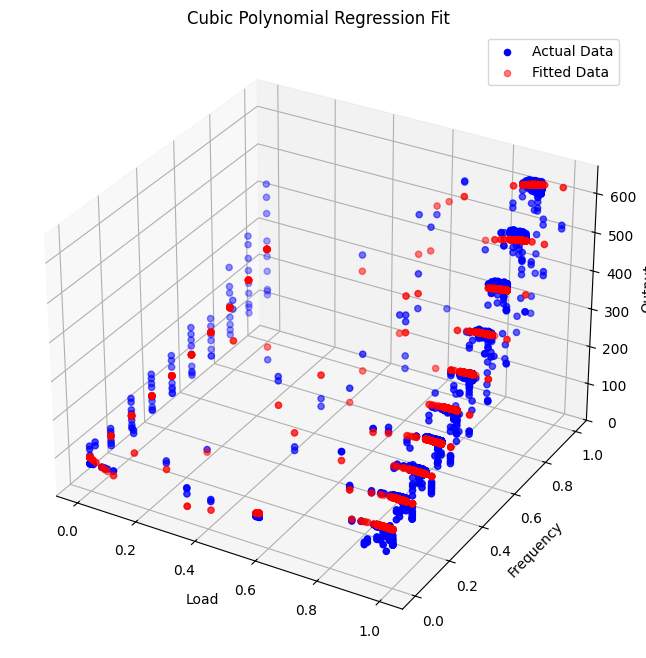

In [10]:

# Prepare data for 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Actual data points
ax.scatter(grouped_data2['load'], grouped_data2['freq'], y, label='Actual Data', color='blue')

# Predicted data points
ax.scatter(grouped_data2['load'], grouped_data2['freq'], y_pred, label='Fitted Data', color='red', alpha=0.5)

ax.set_xlabel('Load')
ax.set_ylabel('Frequency')
ax.set_zlabel('Output')
ax.set_title('Cubic Polynomial Regression Fit')
ax.legend()
plt.show()

In [11]:
def process_inference_data(inference_load, nvidia_log):
    # Initialize a list to store combined data
    merged_data = []

    # Iterate over each inference task
    for idx, row in inference_load.iterrows():
        start_time = row['StartTime']
        end_time = row['EndTime']
        
        # Filter nvidia_log data within the inference time window
        gpu_data = nvidia_log[(nvidia_log['timestamp'] >= start_time) & (nvidia_log['timestamp'] <= end_time)].copy()
        
        if not gpu_data.empty:
            # Calculate the duration between each GPU measurement
            gpu_data['duration'] = gpu_data['timestamp'].diff().dt.total_seconds()
            gpu_data['duration'].fillna(0, inplace=True)
            
            # Calculate watt-seconds for each interval
            gpu_data['watt_seconds'] = gpu_data['power.draw(W)'] * gpu_data['duration']
            
            # Total watt-seconds for the inference task
            total_watt_seconds = gpu_data['watt_seconds'].sum()
            
            total_tokens = row['TotalTokens']
            total_seconds = (end_time - start_time).total_seconds()
               
            # Average GPU frequency during the inference task
            avg_frequency = gpu_data['gpu.frequency(Ghz)'].mean()
            avg_power = gpu_data['power.draw(W)'].mean()
            # Load from gpu
            load = gpu_data['utilization.gpu(%)'].mean()
            
            # Calculate tokens per watt-second
            tokens_per_watt_second = total_tokens / total_watt_seconds if total_watt_seconds > 0 else 0
            
            # Append the results to the list
            merged_data.append({
                'Load': load,
                'AverageFrequency(Ghz)': avg_frequency,
                'TotalWattSeconds': total_watt_seconds,
                'TokensPerWattSecond': tokens_per_watt_second,
                'TokensPerSecond': total_tokens / total_seconds,
                'AveragePower(W)': avg_power
            })
    
    # Create a DataFrame from the merged data
    results_df = pd.DataFrame(merged_data)
    return results_df

/tmp/ipykernel_63275/3682058235.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gpu_data['duration'].fillna(0, inplace=True)
/tmp/ipykernel_63275/3682058235.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

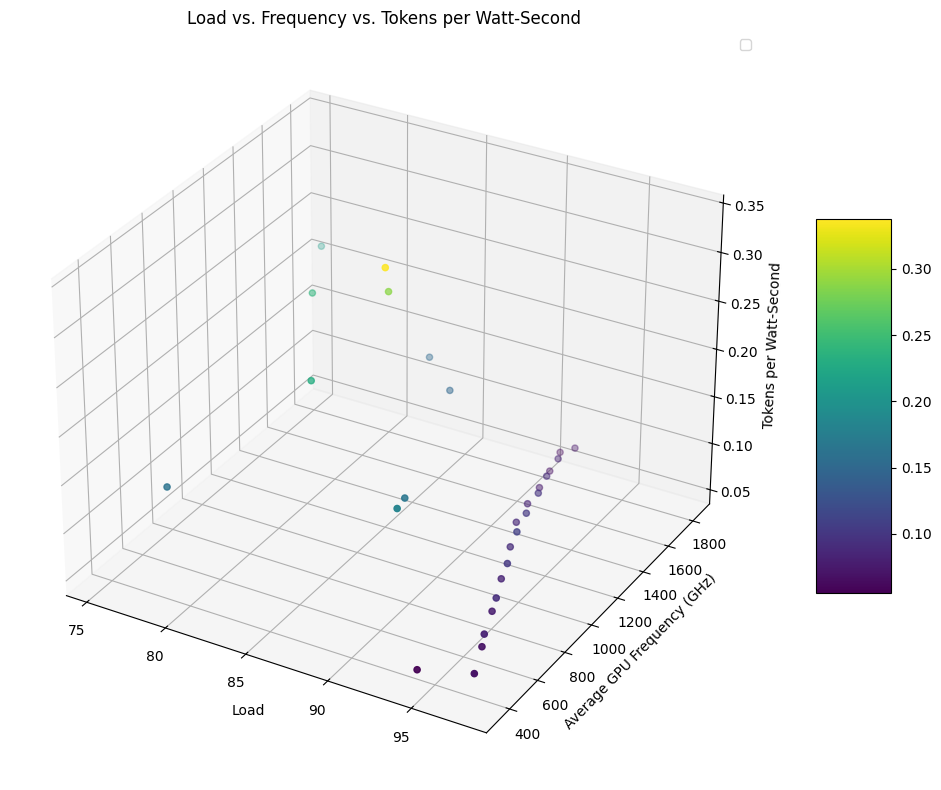

In [28]:

results_df = process_inference_data(inference_load, nvidia_log)

# Remove any entries with zero or missing values to avoid plotting errors
results_df = results_df[(results_df['TotalWattSeconds'] > 0) & (results_df['AverageFrequency(Ghz)'].notnull())]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot
scatter = ax.scatter(results_df['Load'], results_df['AverageFrequency(Ghz)'], results_df['TokensPerWattSecond'], c=results_df['TokensPerWattSecond'], cmap='viridis')

# Optionally, plot the original data points
#ax.scatter(results_df['Load'], results_df['AverageFrequency(Ghz)'], results_df['TokensPerWattSecond'], color='red', label='Actual Data', s=20)

ax.set_xlabel('Load')
ax.set_ylabel('Average GPU Frequency (GHz)')
ax.set_zlabel('Tokens per Watt-Second')
ax.set_title('Load vs. Frequency vs. Tokens per Watt-Second')
ax.legend()

# Add a color bar
fig.colorbar(scatter, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

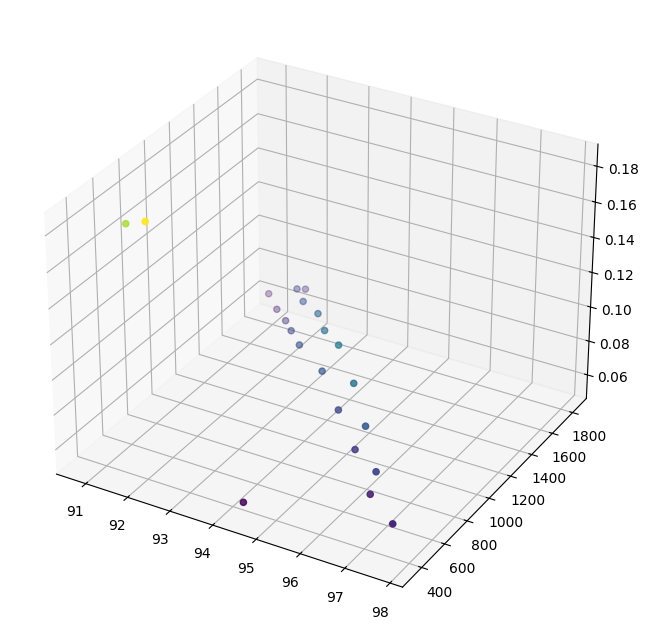

In [29]:
#limit load_df to just loads from 70 to 100 and then plot as above
results_df = results_df[(results_df['Load'] >= 90) ]
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot
scatter = ax.scatter(results_df['Load'], results_df['AverageFrequency(Ghz)'], results_df['TokensPerWattSecond'], c=results_df['TokensPerWattSecond'], cmap='viridis')

plt.show()


/tmp/ipykernel_63275/3682058235.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gpu_data['duration'].fillna(0, inplace=True)
/tmp/ipykernel_63275/3682058235.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

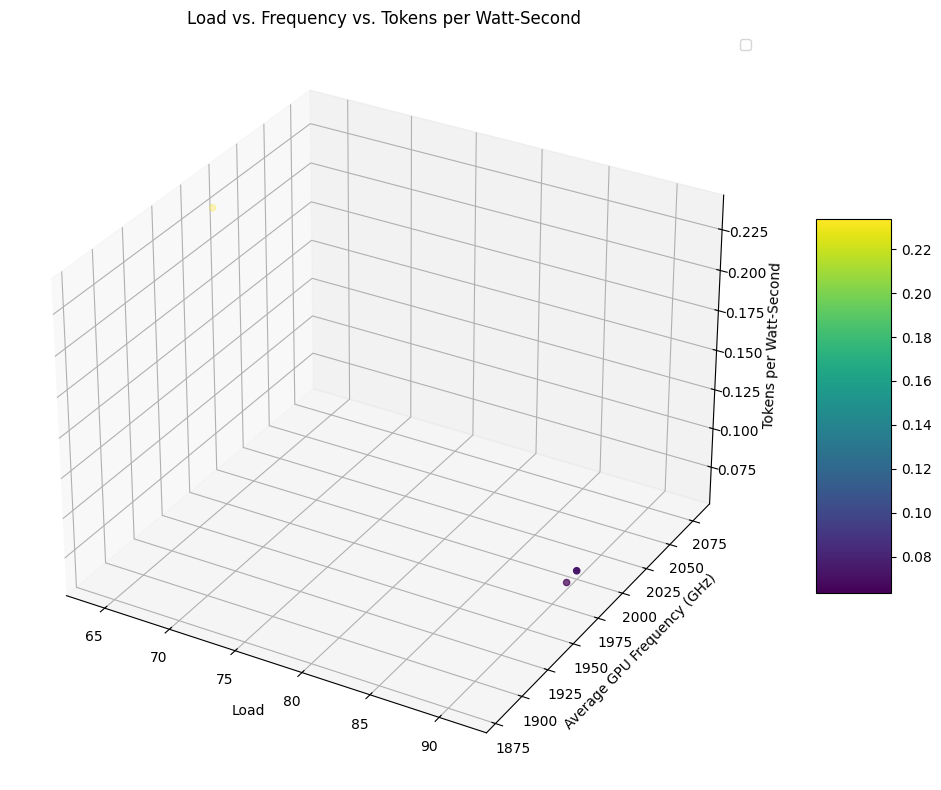

In [30]:
default_results_df = process_inference_data(default_inference_load, default_nvidia_log)

# Remove any entries with zero or missing values to avoid plotting errors
default_results_df = default_results_df[(default_results_df['TotalWattSeconds'] > 0) & (default_results_df['AverageFrequency(Ghz)'].notnull())]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot
scatter = ax.scatter(default_results_df['Load'], default_results_df['AverageFrequency(Ghz)'], default_results_df['TokensPerWattSecond'], c=default_results_df['TokensPerWattSecond'], cmap='viridis')

# Optionally, plot the original data points
#ax.scatter(results_df['Load'], results_df['AverageFrequency(Ghz)'], results_df['TokensPerWattSecond'], color='red', label='Actual Data', s=20)

ax.set_xlabel('Load')
ax.set_ylabel('Average GPU Frequency (GHz)')
ax.set_zlabel('Tokens per Watt-Second')
ax.set_title('Load vs. Frequency vs. Tokens per Watt-Second')
ax.legend()

# Add a color bar
fig.colorbar(scatter, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

In [32]:
#group each load by 10s and find the max tokensperwattsecond in each group
#make load just be the 10th value
results_df['Load'] = results_df['Load'] // 10 * 10
default_results_df['Load'] = default_results_df['Load'] // 10 * 10

In [33]:
# Group by Load and calculate the average frequency for the top quartile of TokensPerWattSecond
def top_quartile_avg_frequency(group):
    # Calculate the 75th percentile (top quartile) threshold
    top_quartile_threshold = group['TokensPerWattSecond'].quantile(0.80)
    # Filter the rows that are in the top quartile
    top_quartile = group[group['TokensPerWattSecond'] >= top_quartile_threshold]
    # Calculate the average frequency for the top quartile
    avg_frequency = top_quartile['AverageFrequency(Ghz)'].mean()
    avg_tokens_per_second = top_quartile['TokensPerSecond'].mean()
    avg_power = top_quartile['AveragePower(W)'].mean()
    return pd.Series({
        'TopQuartileAvgFrequency': avg_frequency,
        'TopQuartileAvgTokensPerSecond': avg_tokens_per_second,
        'TopQuartileTokensPerWattSecond': top_quartile_threshold,
        'TopQuartileAvgPower(W)': avg_power
    })

# Apply the function to each group and reset the index
top_quartile_avg_freq = results_df.groupby('Load').apply(top_quartile_avg_frequency).reset_index()
default_top_quartile_avg_freq = default_results_df.groupby('Load').apply(top_quartile_avg_frequency).reset_index()
# Display the result
#print(top_quartile_avg_freq.head())
#print(default_top_quartile_avg_freq.head())

#join the two dataframes
joined_df = top_quartile_avg_freq.merge(default_top_quartile_avg_freq, on='Load', how='outer', suffixes=('_custom', '_default'))

# calculate the percentage difference in tokens per watt second and tokens per second
joined_df['TokensPerWattSecondDiff'] = (joined_df['TopQuartileTokensPerWattSecond_custom'] - joined_df['TopQuartileTokensPerWattSecond_default']) / joined_df['TopQuartileTokensPerWattSecond_default']
joined_df['TokensPerSecondDiff'] = (joined_df['TopQuartileAvgTokensPerSecond_custom'] - joined_df['TopQuartileAvgTokensPerSecond_default']) / joined_df['TopQuartileAvgTokensPerSecond_default']
joined_df

/tmp/ipykernel_63275/2073254264.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_quartile_avg_freq = results_df.groupby('Load').apply(top_quartile_avg_frequency).reset_index()
/tmp/ipykernel_63275/2073254264.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  default_top_quartile_avg_freq = default_results_df.groupby('Load').apply(top_quartile_avg_frequency).reset_index()


,Load,TopQuartileAvgFrequency_custom,TopQuartileAvgTokensPerSecond_custom,TopQuartileTokensPerWattSecond_custom,TopQuartileAvgPower(W)_custom,TopQuartileAvgFrequency_default,TopQuartileAvgTokensPerSecond_default,TopQuartileTokensPerWattSecond_default,TopQuartileAvgPower(W)_default,TokensPerWattSecondDiff,TokensPerSecondDiff
0,60.0,NaN,NaN,NaN,NaN,1980.0,81.232493,0.233650,537.113333,NaN,NaN
1,90.0,840.0,27.002424,0.099687,224.4758,1980.0,45.095496,0.070864,621.057925,0.406736,-0.401217


In [34]:
#create an index from 10 to 100
index = np.arange(10, 110, 10)
#reindex the joined df and interpolate TopQuartileAvgFrequency_custom
joined_df = joined_df.set_index('Load').reindex(index).reset_index()
joined_df = joined_df.interpolate(method='polynomial', order=1).interpolate(method='ffill').interpolate(method='bfill')
joined_df

ValueError: x and y arrays must have at least 2 entries

In [35]:
load_min = np.arange(1,92,10)
joined_df['Load'] = load_min
joined_df

,Load,TopQuartileAvgFrequency_custom,TopQuartileAvgTokensPerSecond_custom,TopQuartileTokensPerWattSecond_custom,TopQuartileAvgPower(W)_custom,TopQuartileAvgFrequency_default,TopQuartileAvgTokensPerSecond_default,TopQuartileTokensPerWattSecond_default,TopQuartileAvgPower(W)_default,TokensPerWattSecondDiff,TokensPerSecondDiff
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,51,NaN,NaN,NaN,NaN,1980.0,81.232493,0.233650,537.113333,NaN,NaN
6,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,81,840.0,27.002424,0.099687,224.4758,1980.0,45.095496,0.070864,621.057925,0.406736,-0.401217
9,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#output to csv as load,power_percent,frequency_percent,power

In [36]:
#get the min and max frequencies from nvidia log
min_freq = nvidia_log['gpu.frequency(Ghz)'].min()
max_freq = nvidia_log['gpu.frequency(Ghz)'].max()
min_power = nvidia_log['power.draw(W)'].min()
max_power = nvidia_log['power.draw(W)'].max()


In [21]:
model

LinearRegression()

In [37]:
#output csv: load, power_percent, frequency_percent, power
import math
output_df = pd.DataFrame()
output_df['load'] = joined_df['Load']
output_df['power_percent'] = round((joined_df['TopQuartileAvgPower(W)_custom'] - min_power) / (max_power - min_power), 1)
output_df['frequency_percent'] = round((joined_df['TopQuartileAvgFrequency_custom'] - min_freq) / (max_freq - min_freq), 1)
output_df['power'] = round(joined_df['TopQuartileAvgPower(W)_custom'])

#if frequency_percent is 0 then replace it with min
output_df.loc[output_df['frequency_percent'] == 0, 'frequency_percent'] = .1 
output_df
output_df.to_csv(f'power_percentages_{model}.csv', index=False)

In [38]:
output_df

,load,power_percent,frequency_percent,power
0,1,NaN,NaN,NaN
1,11,NaN,NaN,NaN
2,21,NaN,NaN,NaN
3,31,NaN,NaN,NaN
4,41,NaN,NaN,NaN
5,51,NaN,NaN,NaN
6,61,NaN,NaN,NaN
7,71,NaN,NaN,NaN
8,81,0.3,0.3,224.0
9,91,NaN,NaN,NaN


In [39]:
# Find the index of the maximum TokensPerWattSecond for each Load
#frequency search
idx = results_df.groupby('Load')['TokensPerWattSecond'].idxmax()
results_df.loc[idx]

,Load,AverageFrequency(Ghz),TotalWattSeconds,TokensPerWattSecond,TokensPerSecond,AveragePower(W)
4,90.0,510.0,158.5048,0.18296,26.90167,164.181111


In [28]:
#default
idx = results_df.groupby('Load')['TokensPerWattSecond'].idxmax()
results_df.loc[idx]

,Load,AverageFrequency(Ghz),TotalWattSeconds,TokensPerWattSecond,TokensPerSecond,AveragePower(W)
1,30.0,345.0,15.47532,1.873952,99.315068,112.080000
250,60.0,1335.0,28.92825,1.832119,182.758621,224.160000
199,70.0,1170.0,24.08742,2.283350,170.278638,190.810000
44,80.0,510.0,18.05808,1.550552,138.613861,132.520000
36,90.0,510.0,1323.81390,0.756904,99.335779,132.995065


Model coefficients:
load: 3.098096349025773e-09
freq: 1.2056019934340253e-08
load^2: 1.2273767430102202e-07
load freq: 1.3040489311971417e-06
freq^2: 5.2455174457926234e-06
load^3: -1.3474959435326288e-05
load^2 freq: 3.1436813901162346e-06
load freq^2: -2.3145458260058045e-07
freq^3: 1.488598866925822e-09
Intercept: 1.3890422381105683


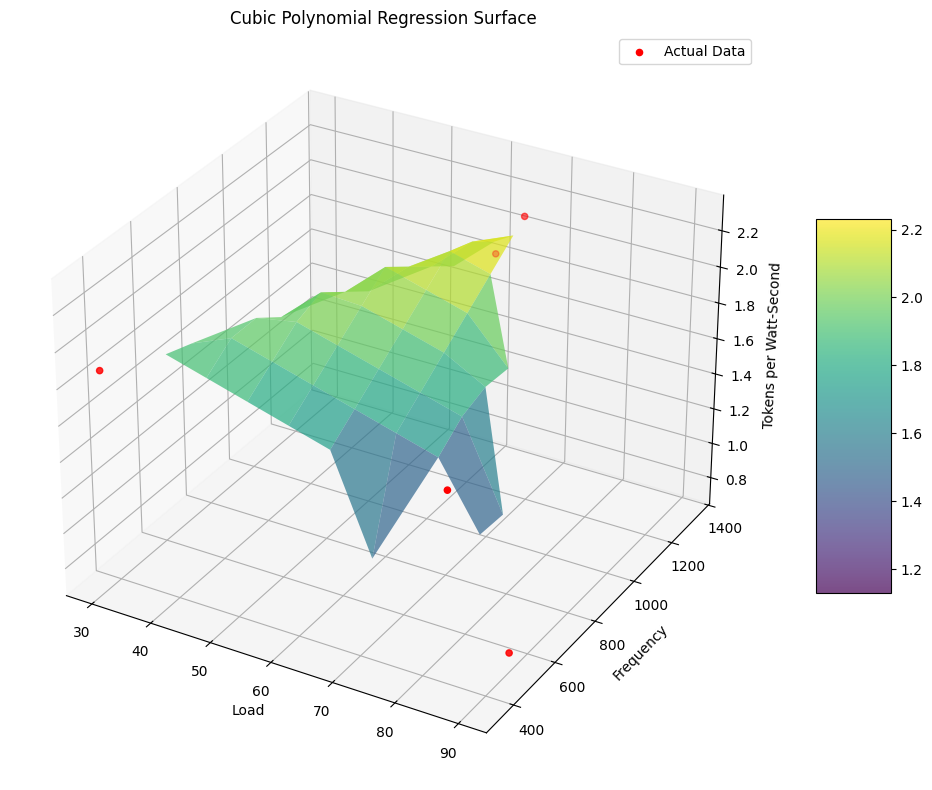

In [30]:
#in results_df.loc[idx] fit a cubic polynomial to AverageFrequency(Ghz) and TokensPerWattSecond
# Extract the relevant data
load = results_df.loc[idx, 'Load']
freq = results_df.loc[idx, 'AverageFrequency(Ghz)']
tokens_per_watt_second = results_df.loc[idx, 'TokensPerWattSecond']

# Create a DataFrame with the extracted data
data = pd.DataFrame({
    'load': load,
    'freq': freq,
    'tokens_per_watt_second': tokens_per_watt_second
})

# Create polynomial features up to degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(data[['load', 'freq']])
# Fit the linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_poly, data['tokens_per_watt_second'])
# Get the model coefficients
coefficients = model.coef_
intercept = model.intercept_

# Display the coefficients with their corresponding feature names
print("Model coefficients:")
feature_names = poly.get_feature_names_out(['load', 'freq'])
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")
print(f"Intercept: {intercept}")

#display the graph
# Create a grid for load and frequency
load_unique = np.linspace(load.min(), load.max(), 10)
freq_unique = np.linspace(freq.min(), freq.max(), 10)
load_grid, freq_grid = np.meshgrid(load_unique, freq_unique)

# Interpolate the predicted output onto the grid
from scipy.interpolate import griddata

# Points where you have data
points = np.column_stack((data['load'], data['freq']))
values = data['tokens_per_watt_second']

# Grid the data
output_grid = griddata(points, values, (load_grid, freq_grid), method='linear')

# Plotting the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(load_grid, freq_grid, output_grid, cmap='viridis', alpha=0.7, edgecolor='none')

# Optionally, plot the original data points
ax.scatter(load, freq, tokens_per_watt_second, color='red', label='Actual Data', s=20)

ax.set_xlabel('Load')
ax.set_ylabel('Frequency')
ax.set_zlabel('Tokens per Watt-Second')
ax.set_title('Cubic Polynomial Regression Surface')
ax.legend()

# Add a color bar
fig.colorbar(surface, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


/tmp/ipykernel_61427/1125228744.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gpu_data['duration'].fillna(0, inplace=True)
/tmp/ipykernel_61427/1125228744.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

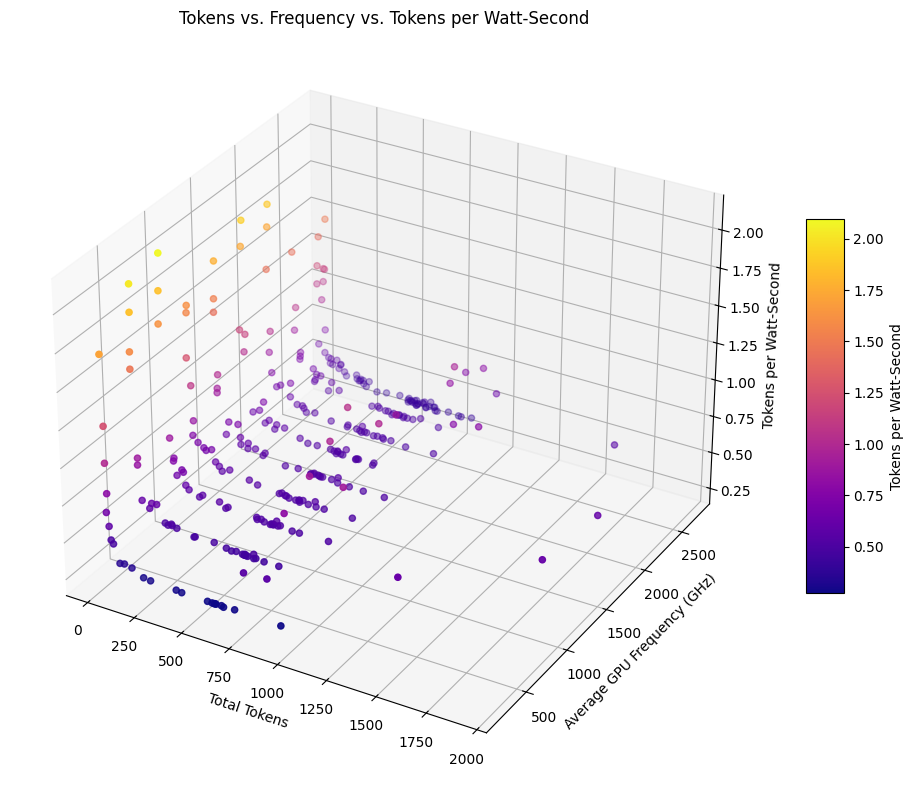

In [ ]:

# Initialize a list to store combined data
merged_data = []

# Iterate over each inference task
for idx, row in inference_load.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    
    # Filter nvidia_log data within the inference time window
    gpu_data = nvidia_log[(nvidia_log['timestamp'] >= start_time) & (nvidia_log['timestamp'] <= end_time)].copy()
    
    if not gpu_data.empty:
        # Calculate the duration between each GPU measurement
        gpu_data['duration'] = gpu_data['timestamp'].diff().dt.total_seconds()
        gpu_data['duration'].fillna(0, inplace=True)
        
        # Calculate watt-seconds for each interval
        gpu_data['watt_seconds'] = gpu_data['power.draw(W)'] * gpu_data['duration']
        
        # Total watt-seconds for the inference task
        total_watt_seconds = gpu_data['watt_seconds'].sum()
        
        # Average GPU frequency during the inference task
        avg_frequency = gpu_data['gpu.frequency(Ghz)'].mean()
        
        # Total tokens from inference_load
        total_tokens = row['TotalTokens']
        
        # Calculate tokens per watt-second
        tokens_per_watt_second = total_tokens / total_watt_seconds if total_watt_seconds > 0 else 0
        
        # Append the results to the list
        merged_data.append({
            'TotalTokens': total_tokens,
            'AverageFrequency(Ghz)': avg_frequency,
            'TotalWattSeconds': total_watt_seconds,
            'TokensPerWattSecond': tokens_per_watt_second
        })

# Create a DataFrame from the merged data
results_df = pd.DataFrame(merged_data)

# Remove any entries with zero or missing values to avoid plotting errors
results_df = results_df[(results_df['TotalWattSeconds'] > 0) & (results_df['AverageFrequency(Ghz)'].notnull())]

# # Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x2 = results_df['TotalTokens']
y2 = results_df['AverageFrequency(Ghz)']
z2 = results_df['TokensPerWattSecond']

scatter2 = ax.scatter(x2, y2, z2, c=z2, cmap='plasma')
ax.set_xlabel('Total Tokens')
ax.set_ylabel('Average GPU Frequency (GHz)')
ax.set_zlabel('Tokens per Watt-Second')
ax.set_title('Tokens vs. Frequency vs. Tokens per Watt-Second')

# Add a color bar for the second plot
cbar2 = fig.colorbar(scatter2, ax=ax, shrink=0.5, aspect=10)
cbar2.set_label('Tokens per Watt-Second')

plt.tight_layout()
plt.show()

In [ ]:
results_df

,TotalTokens,AverageFrequency(Ghz),TotalWattSeconds,TokensPerWattSecond
0,695,210.000000,2457.42845,0.282816
1,29,210.000000,23.29374,1.244970
2,746,210.000000,1348.56501,0.553181
3,27,210.000000,40.32098,0.669627
4,626,210.000000,2218.96359,0.282114
...,...,...,...,...
364,656,2664.893617,1639.72810,0.400066
365,244,2663.823529,559.93197,0.435767
366,562,2665.769231,1359.43863,0.413406
367,234,2655.000000,489.60978,0.477932
